# Ross Sea synthetic gravity inversion

Here we try to recover the true bathymetry of the Ross Sea from a synthetic airborne gravity survey. See notebook `Ross_Sea_synthetic_model.ipynb` for the creation of this synthetic gravity data and the low-resolution starting model of bathymetry. 

import packages

In [1]:
from __future__ import annotations

%load_ext autoreload
%autoreload 2

import logging
import pathlib
import pickle
import verde as vd
import xarray as xr
import pandas as pd
import numpy as np
from polartoolkit import maps, fetch, regions
from polartoolkit import utils as polar_utils
import string
import os
import RIS_gravity_inversion.synthetic as RIS_synth
import RIS_gravity_inversion.plotting as RIS_plotting
import pygmt
import copy
from tqdm.autonotebook import tqdm

os.environ['POLARTOOLKIT_HEMISPHERE']='south'

logging.getLogger().setLevel(logging.INFO)

from invert4geom import inversion, plotting, synthetic, uncertainty, utils, regional, cross_validation, optimization

# Get synthetic model data

INFO:root:using preprocessed 5km grid since spacing is > 5km
INFO:root:returning grid with new region and/or registration, same spacing
INFO:root:returning grid with new region and/or registration, same spacing


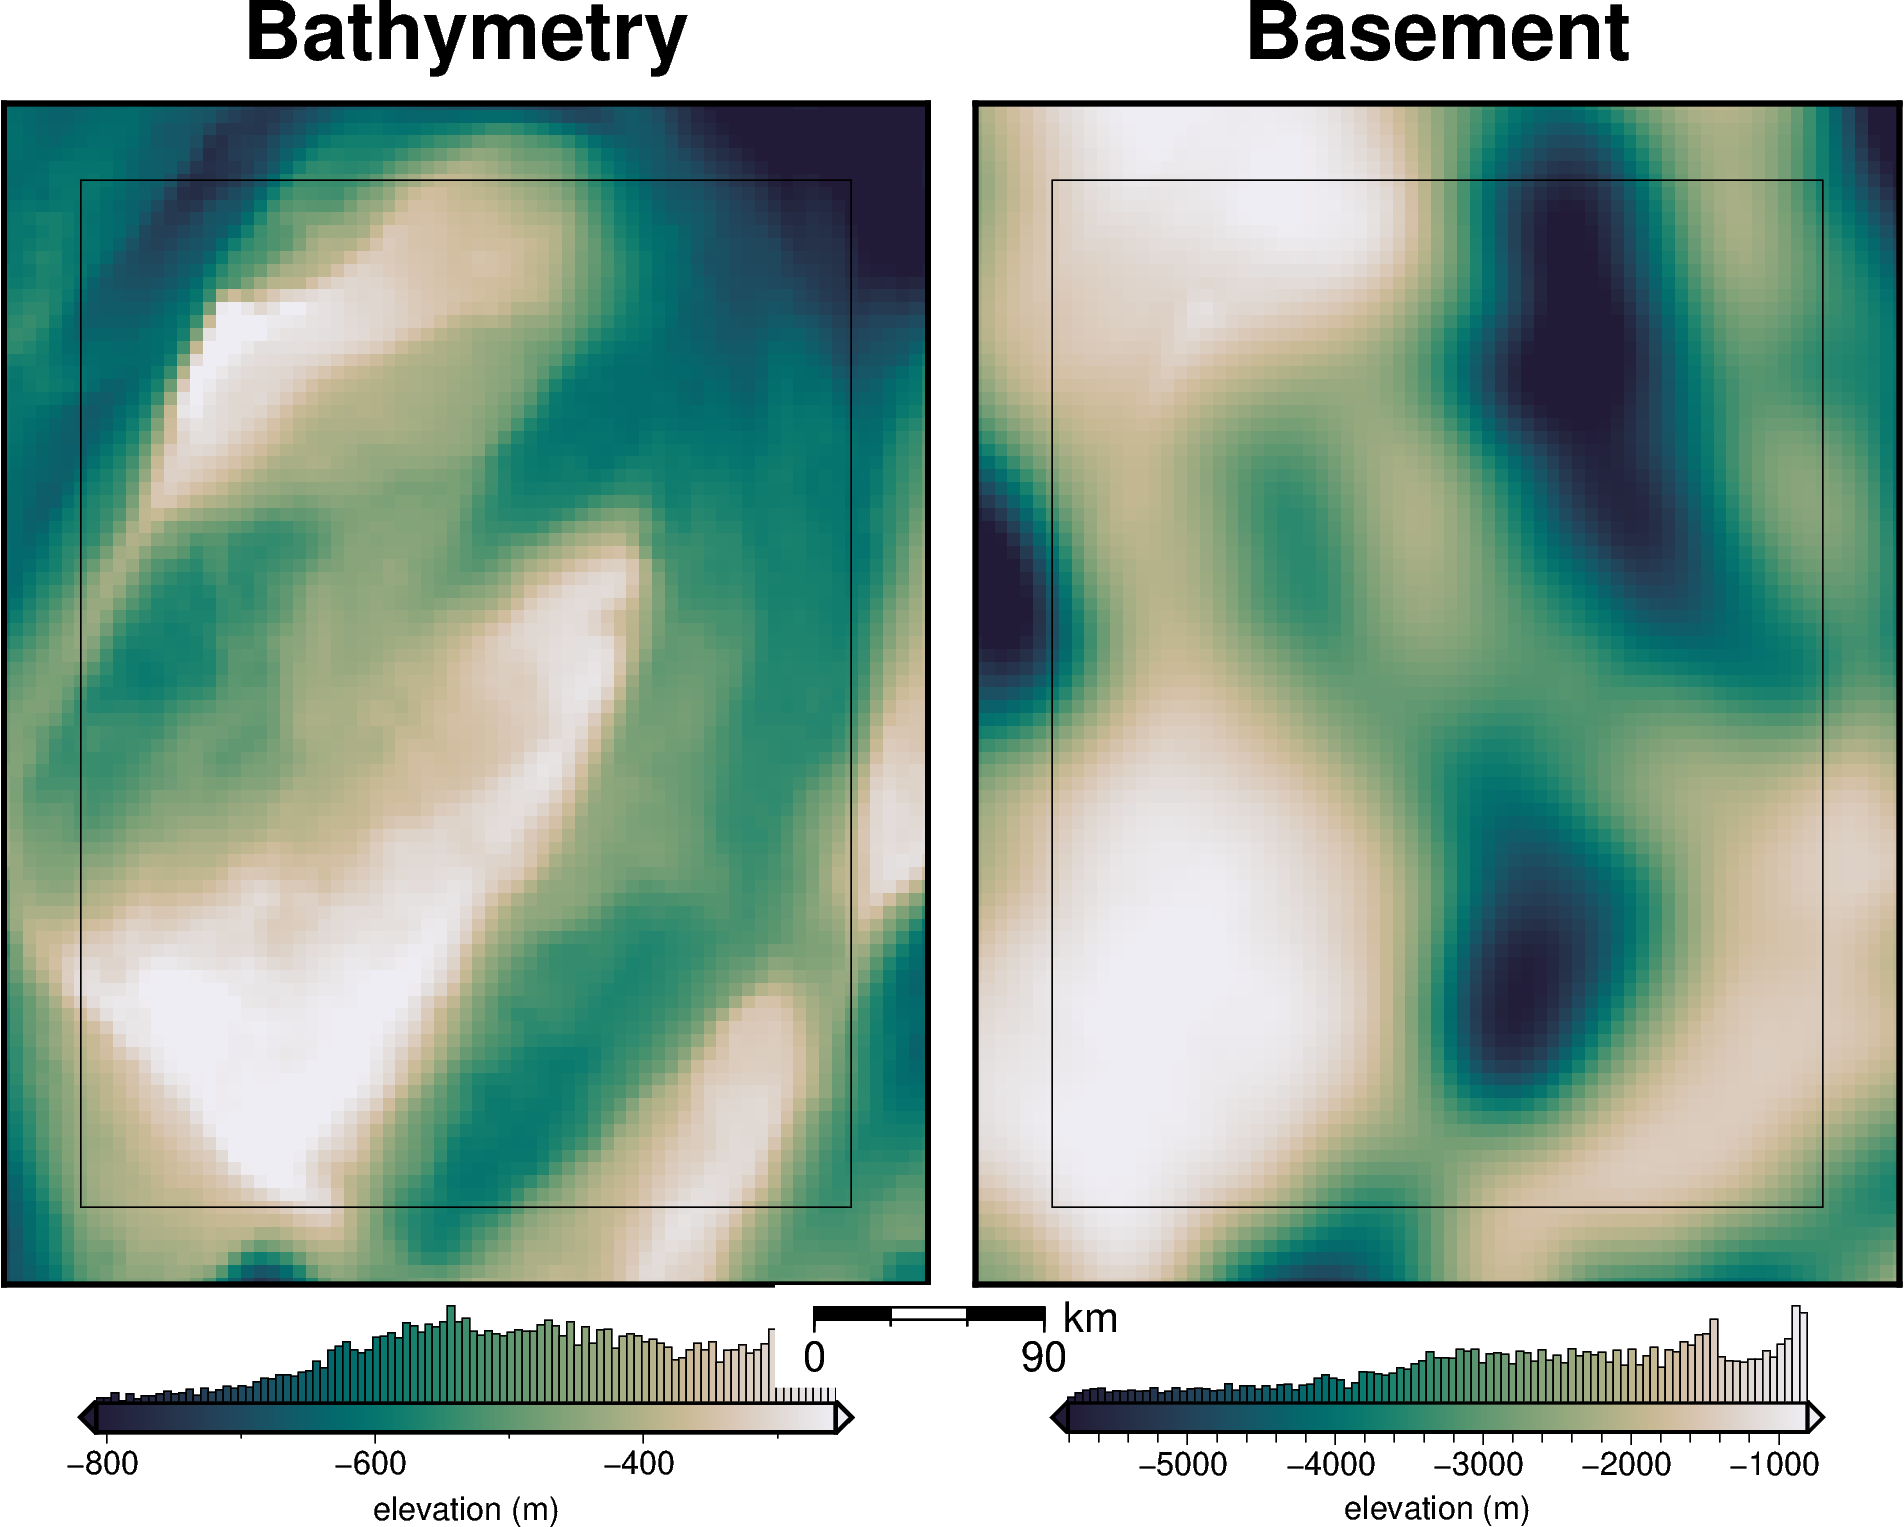

  0%|          | 0/4941 [00:00<?, ?it/s]

  0%|          | 0/4941 [00:00<?, ?it/s]

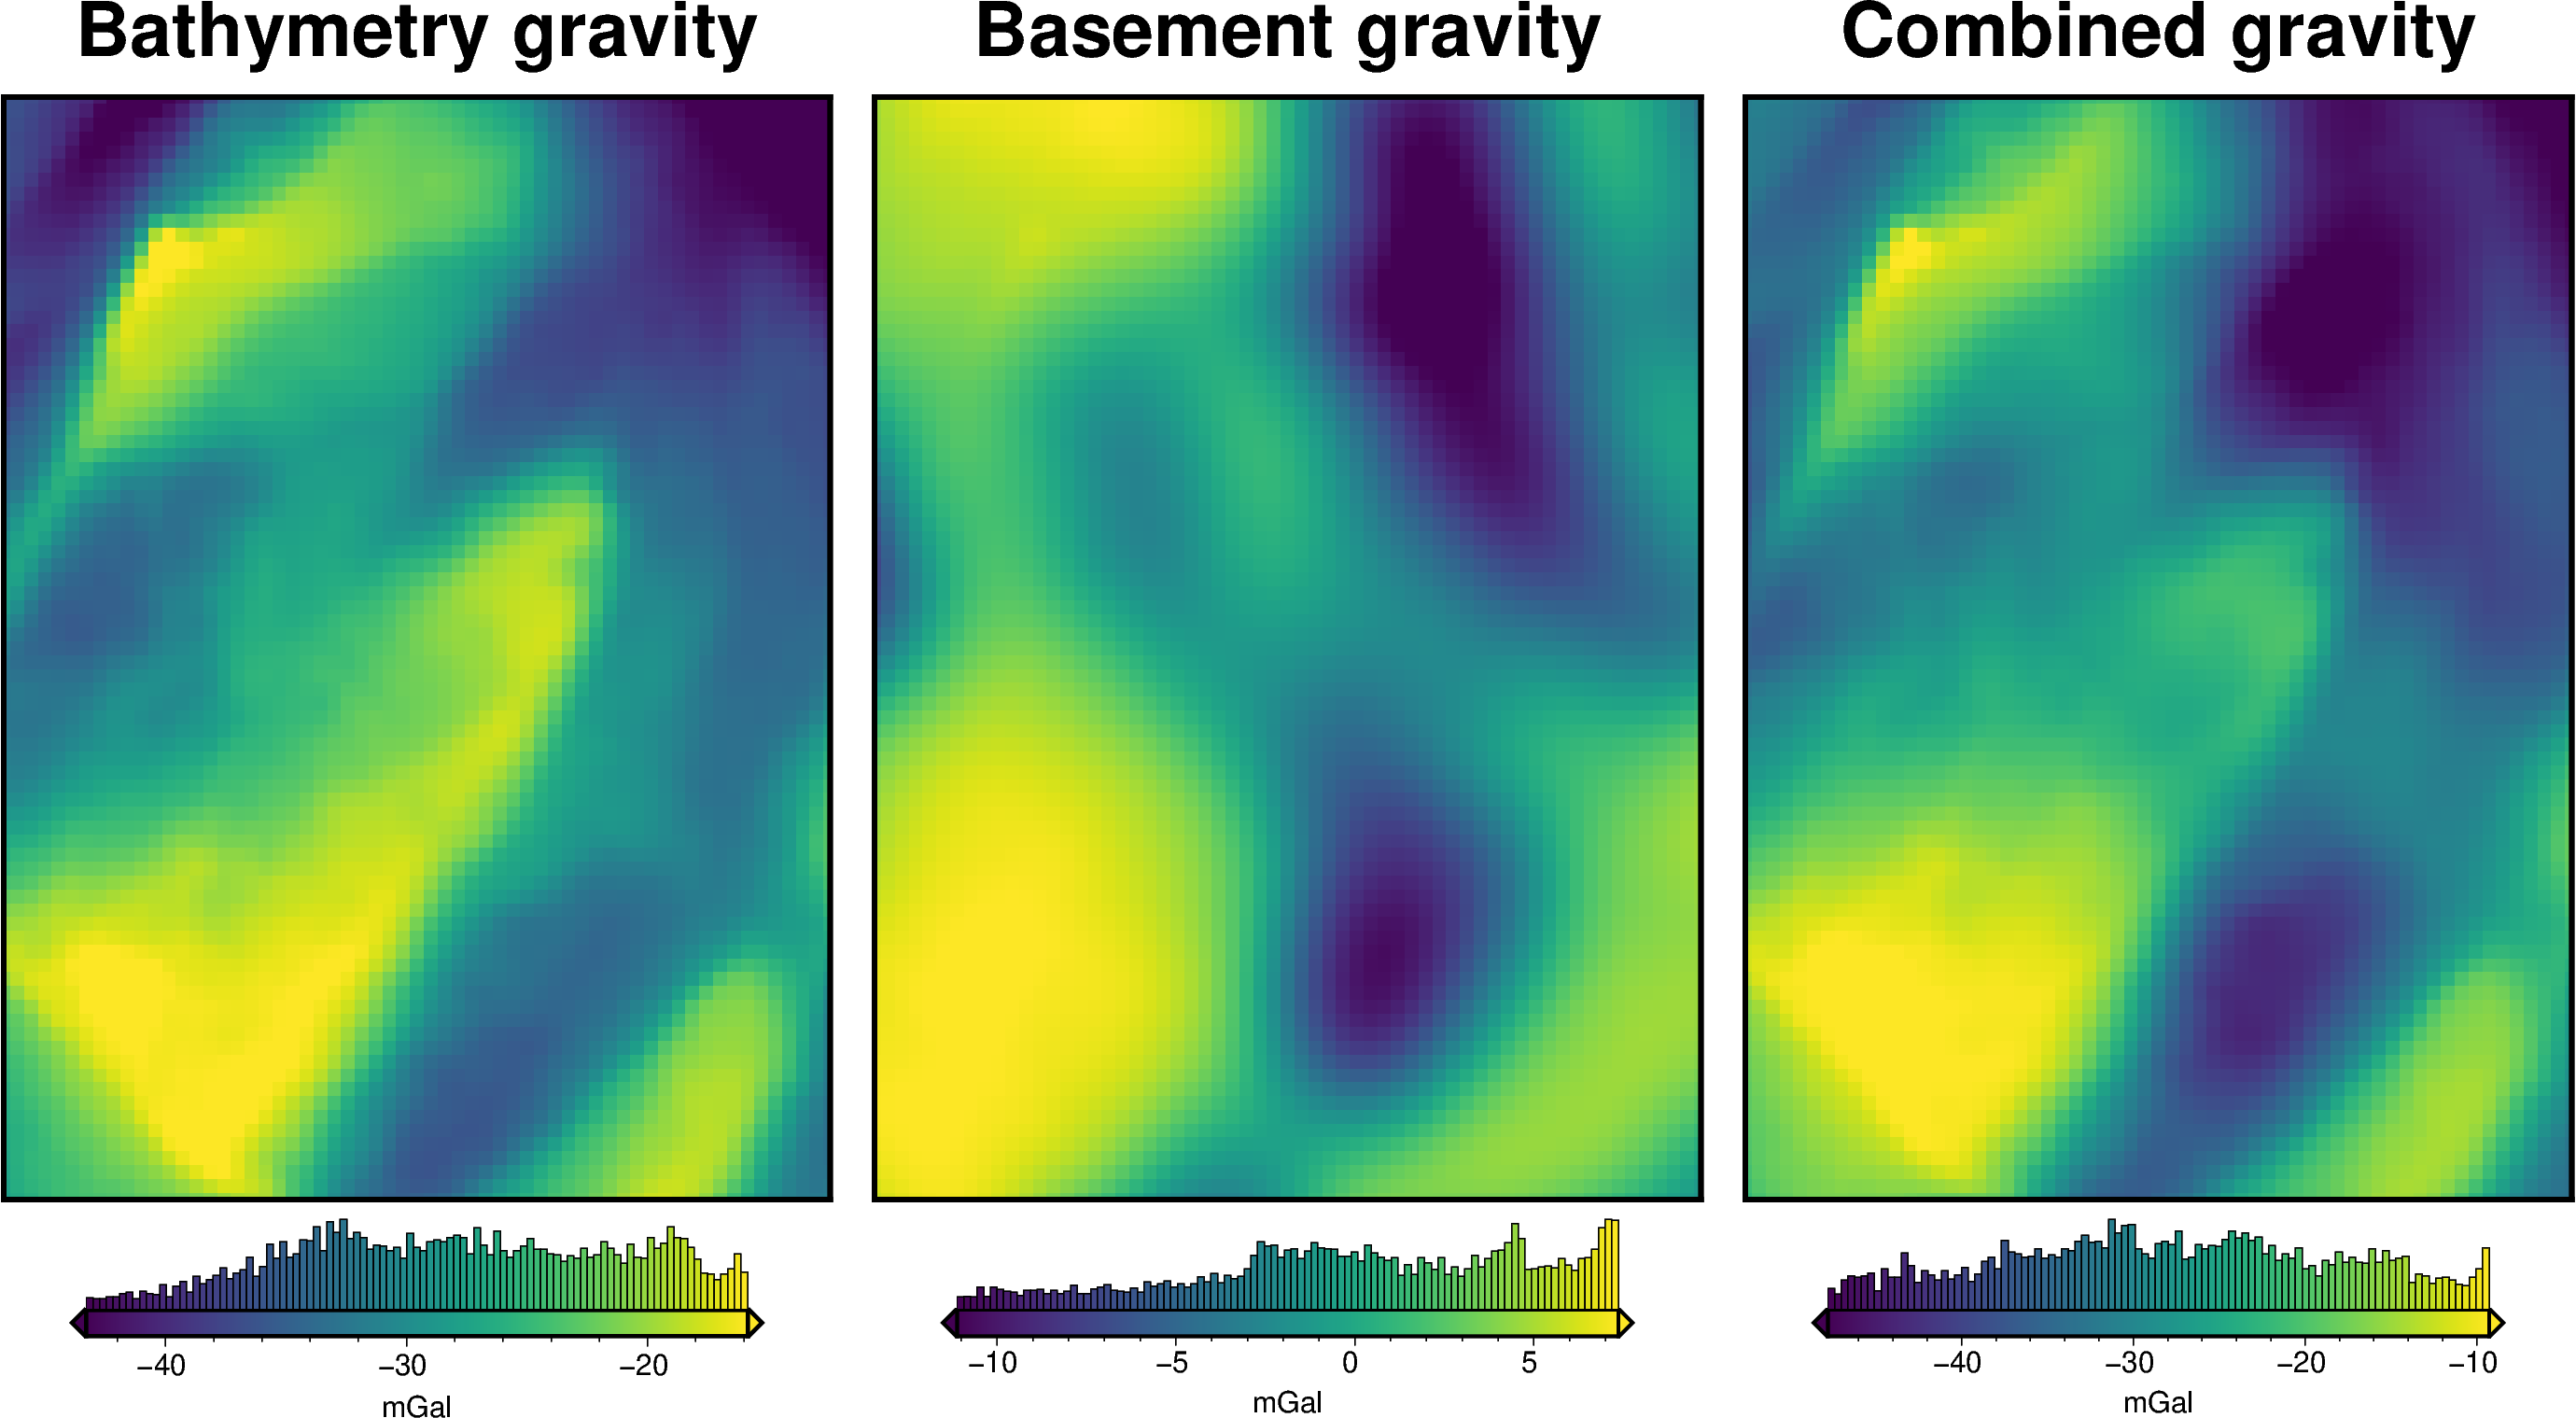

In [2]:
# set grid parameters
spacing = 5e3
inversion_region = (-40e3, 260e3, -1800e3, -1400e3)

bathymetry, basement, grav_df = RIS_synth.load_synthetic_model(
    spacing=spacing,
    buffer=spacing*6,
    basement=True,
    gravity_noise=0,
)
buffer_region = polar_utils.get_grid_info(bathymetry)[1]

In [3]:
grav_df.describe()

,northing,easting,upward,bathymetry_grav,basement_grav,disturbance,uncert,gravity_anomaly
count,4.941000e+03,4941.00000,4941.0,4941.000000,4.941000e+03,4941.000000,4941.0,4941.000000
mean,-1.600000e+06,110000.00000,1000.0,-28.076339,-1.104426e-15,-28.076339,0.0,-28.076339
std,1.169164e+05,88042.99419,0.0,7.267542,5.084792e+00,10.422159,0.0,10.422159
min,-1.800000e+06,-40000.00000,1000.0,-50.834525,-1.301714e+01,-54.808150,0.0,-54.808150
25%,-1.700000e+06,35000.00000,1000.0,-33.380910,-3.033944e+00,-35.767154,0.0,-35.767154
50%,-1.600000e+06,110000.00000,1000.0,-28.037682,3.065578e-01,-28.122260,0.0,-28.122260
75%,-1.500000e+06,185000.00000,1000.0,-21.983838,4.323170e+00,-20.221411,0.0,-20.221411
max,-1.400000e+06,260000.00000,1000.0,-13.088736,7.658592e+00,-5.937589,0.0,-5.937589


# Run ensemble of inversions with varying constraint spacing

In [4]:
inversion_area = (inversion_region[1]-inversion_region[0])/1000*(inversion_region[3]-inversion_region[2])/1000
inversion_area

120000.0

In [5]:
# constraint_spacings = np.linspace(10e3, 200e3, 11)
# constraint_spacings = [int(x) for x in np.linspace(1, 25, 10)]

# Define number of constraints on log scale
constraint_numbers = np.unique(np.round(np.geomspace(1,25,10)))
# constraint_numbers = np.linspace(1, 25**2, 10).astype(int)
constraint_numbers = [int(i) for i in constraint_numbers]
constraint_numbers.reverse()
# constraint_numbers = [constraint_numbers[0], constraint_numbers[4]]

constraint_numbers

[25, 17, 12, 9, 6, 4, 3, 2, 1]

ERROR:invert4geom:Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.


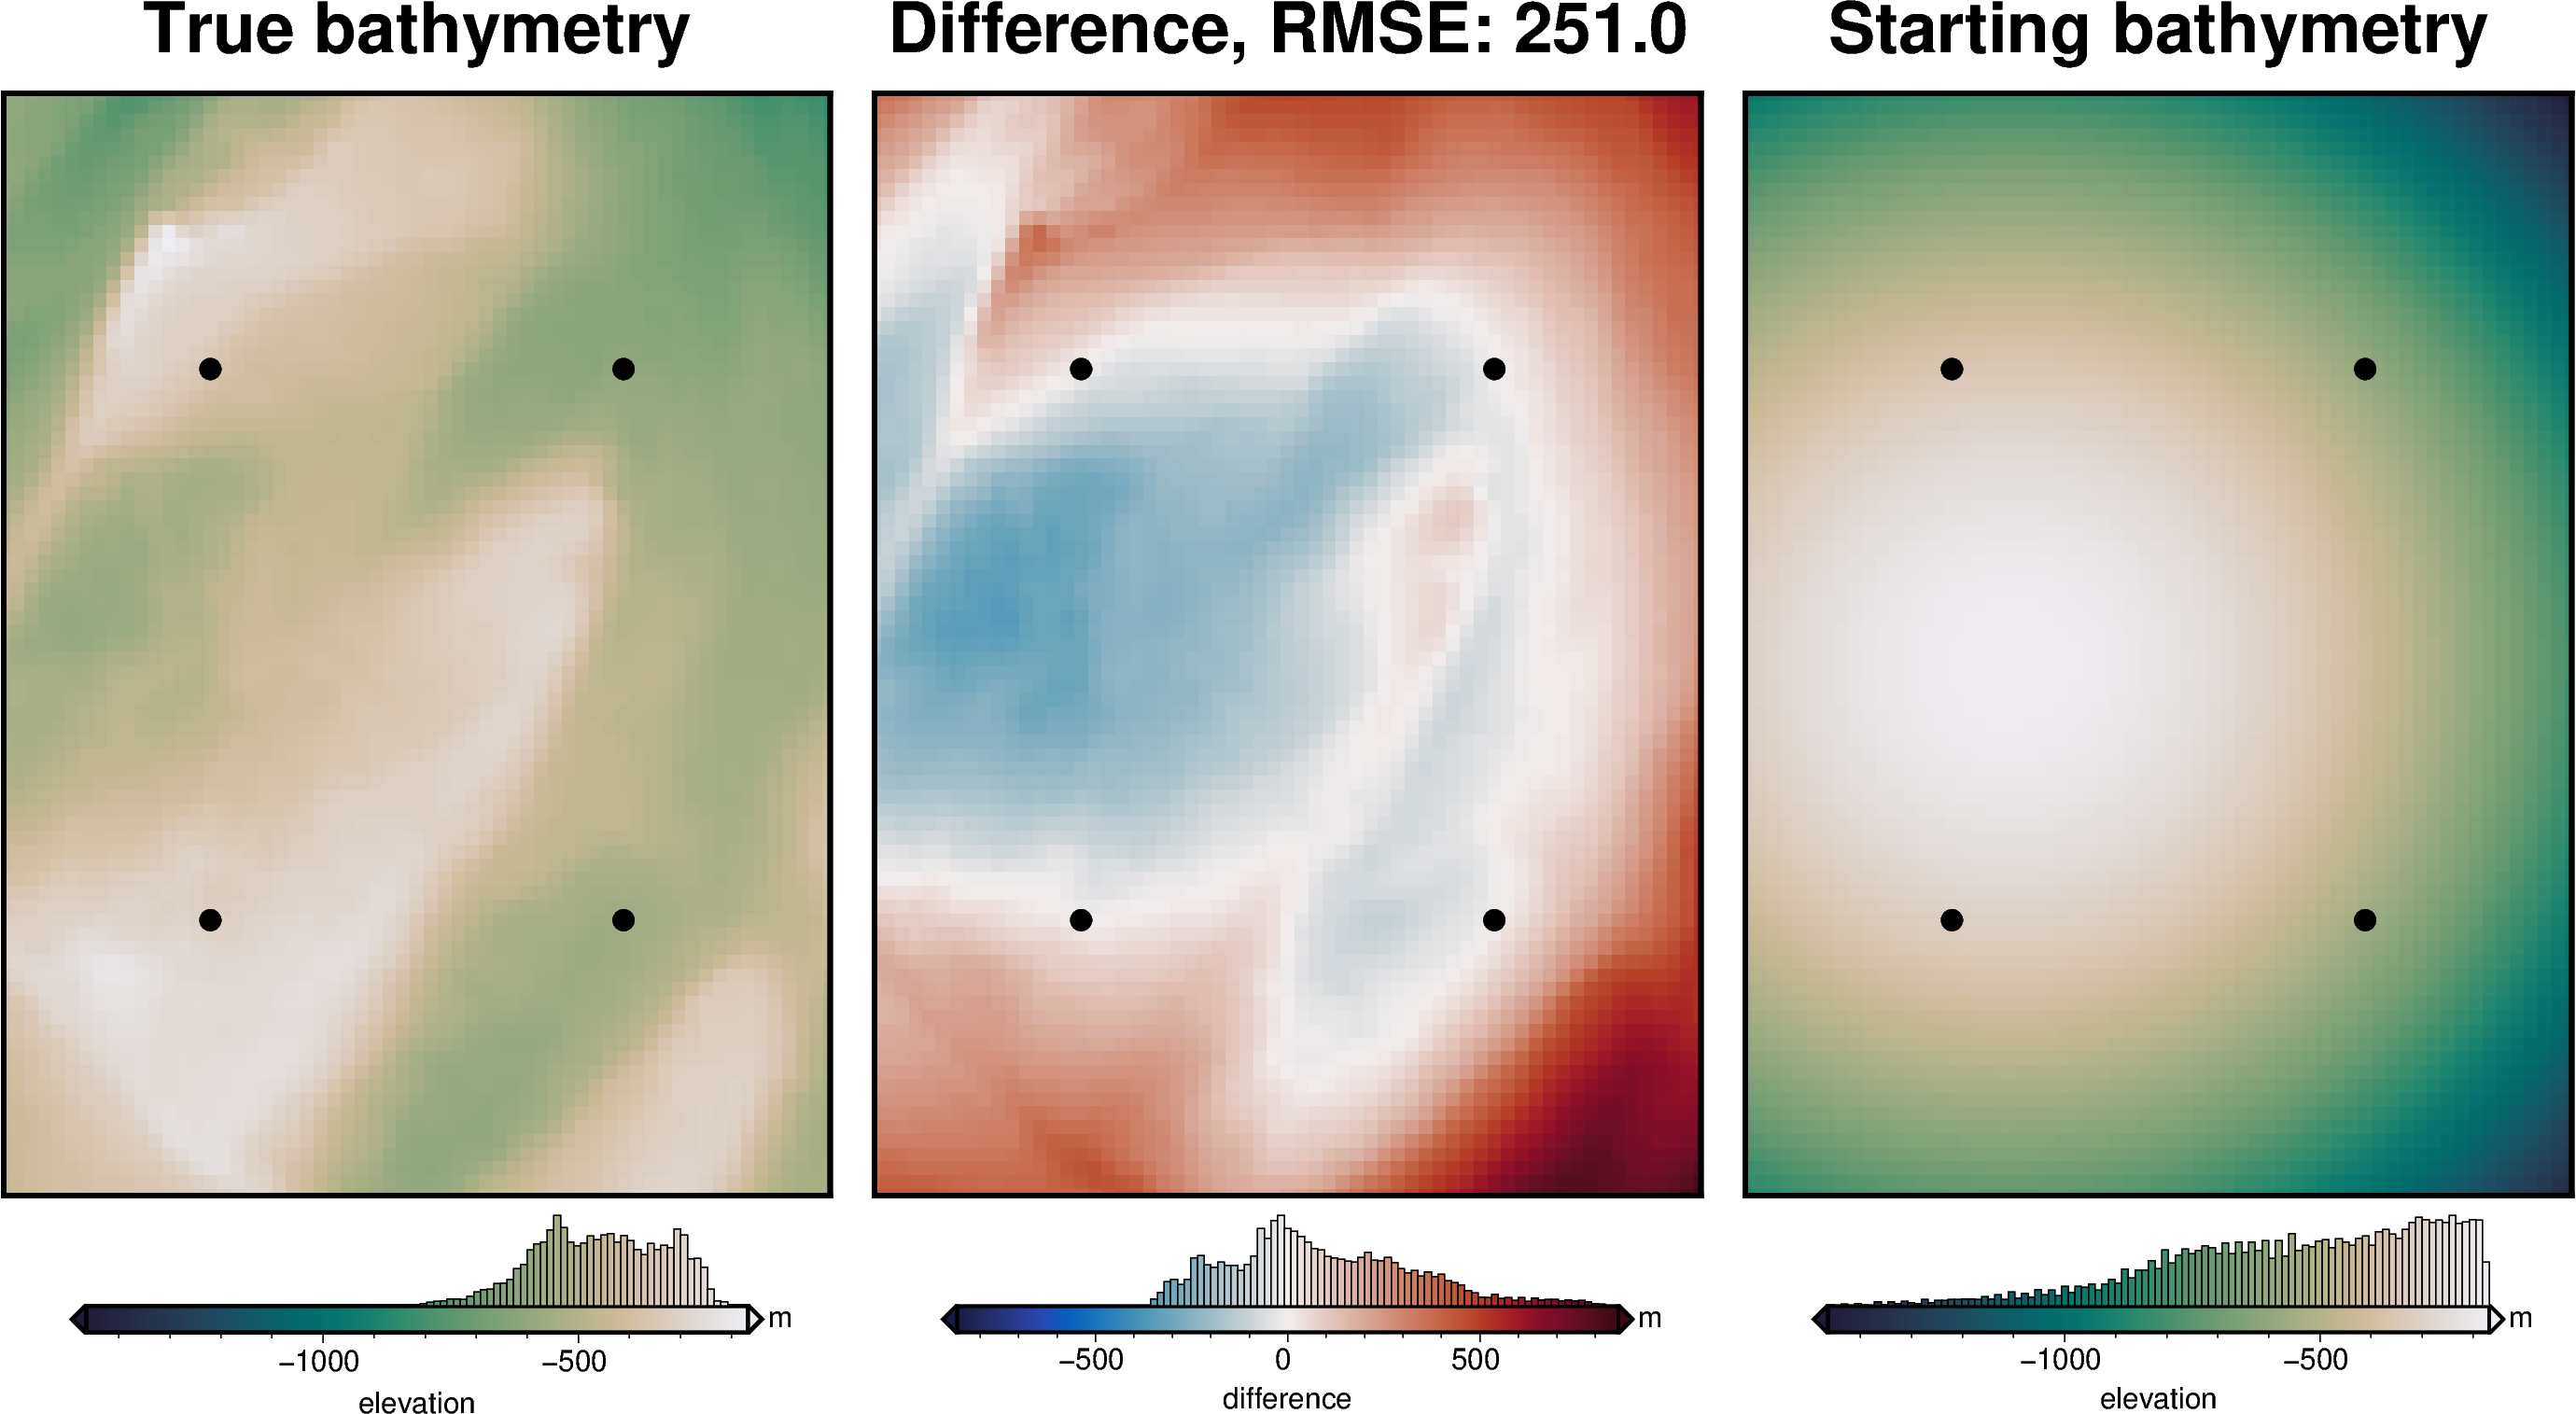

,northing,easting,upward
0,-1700000.0,35000.0,-312.992310
1,-1700000.0,185000.0,-558.086975
2,-1500000.0,35000.0,-359.682739
3,-1500000.0,185000.0,-591.178955


In [6]:
# semi-regularly spaced
constraint_points = RIS_synth.constraint_layout_number(
    # spacing=(constraint_numbers[-4], constraint_numbers[-4]),
    shape=(constraint_numbers[-2], constraint_numbers[-2]),
    # num_constraints=constraint_numbers[-2],
    region=inversion_region,
)

# # sample true topography at these points
constraint_points = utils.sample_grids(
    constraint_points,
    bathymetry,
    "upward",
    coord_names=("easting", "northing"),
)

# grid the sampled values using verde
starting_bathymetry = utils.create_topography(
    method="splines",
    region=buffer_region,
    spacing=spacing,
    constraints_df=constraint_points,
    dampings=None,
)

# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    fig_height=10,
    plot=True,
    plot_type="pygmt",
    cmap="rain",
    reverse_cpt=True,
    diff_cmap="balance+h0",
    grid1_name="True bathymetry",
    grid2_name="Starting bathymetry",
    title="Difference",
    title_font="18p,Helvetica-Bold,black",
    cbar_unit="m",
    cbar_label="elevation",
    RMSE_decimals=0,
    region=inversion_region,
    inset=False,
    hist=True,
    cbar_yoffset=1,
    label_font="16p,Helvetica,black",
    points=constraint_points.rename(columns={"easting": "x", "northing": "y"}),
    points_style="p.2c",
)
constraint_points

In [9]:
# the true density contrast is 1476 kg/m3
density_contrast = 1476

# set the reference level from the prisms to 0
zref = 0

grav_dfs = []
grav_grids = []
starting_prism_layers = []
constraints_dfs = []
constraints_spacings = []
for i, c in enumerate(tqdm(constraint_numbers)):
    # make constraint points
    constraint_points = RIS_synth.constraint_layout_number(
        shape=(c, c),
        region=inversion_region,
        padding=-spacing,
    )

    # sample true topography at these points
    constraint_points = utils.sample_grids(
        constraint_points,
        bathymetry,
        "upward",
        coord_names=("easting", "northing"),
    )
    constraints_dfs.append(constraint_points)
    # grid the sampled values using verde
    starting_bathymetry = utils.create_topography(
        method="splines",
        region=buffer_region,
        spacing=spacing,
        constraints_df=constraint_points,
        dampings=None,
    )

    # min_dist = utils.dist_nearest_points(
    #     targets=constraint_points,
    #     data=starting_bathymetry,
    # ).min_dist
    # constraint_spacing = float(min_dist.median()*2)
    x_spacing=(inversion_region[1]-inversion_region[0])/c
    y_spacing=(inversion_region[3]-inversion_region[2])/c
    constraint_spacing = (x_spacing + y_spacing)/2
    constraints_spacings.append(constraint_spacing)

    density_grid = xr.where(
        starting_bathymetry >=  zref,
        density_contrast,
        -density_contrast,
    )

    # create layer of prisms
    starting_prisms = utils.grids_to_prisms(
        starting_bathymetry,
        zref,
        density=density_grid,
    )
    starting_prism_layers.append(starting_prisms)

    # copy gravity dataframe
    df = copy.deepcopy(grav_df)

    df["starting_gravity"] = starting_prisms.prism_layer.gravity(
        coordinates=(
            df.easting,
            df.northing,
            df.upward,
        ),
        field="g_z",
        progressbar=False,
    )

    # calculate the true residual misfit
    df["true_res"] = df.bathymetry_grav -df.starting_gravity

    # estimate regional
    df = regional.regional_separation(
        grav_df=df,
        method="constraints",
        grid_method="eq_sources",
        constraints_df=constraint_points,
        damping=None,
        depth="default",
        block_size=None,
    )

    grav_dfs.append(df)

    grav_grid = df.set_index(["northing", "easting"]).to_xarray()
    grav_grids.append(grav_grid)

  0%|          | 0/9 [00:00<?, ?it/s]

ERROR:invert4geom:Cannot have number of splits n_splits=5 greater than the number of samples: n_samples=4.


<Axes: >

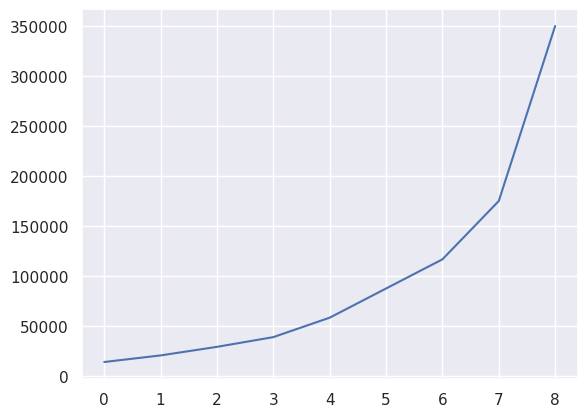

In [10]:
pd.Series(constraints_spacings).plot()

<Axes: >

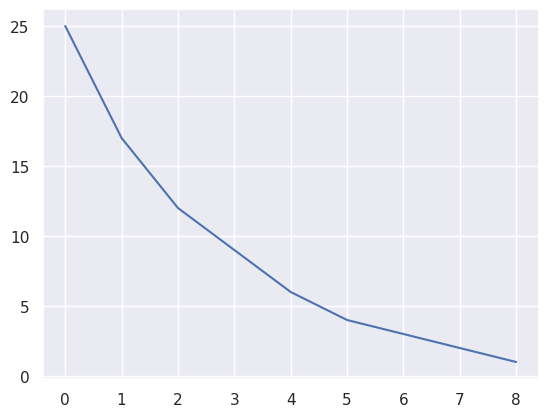

In [11]:
pd.Series(constraint_numbers).plot()

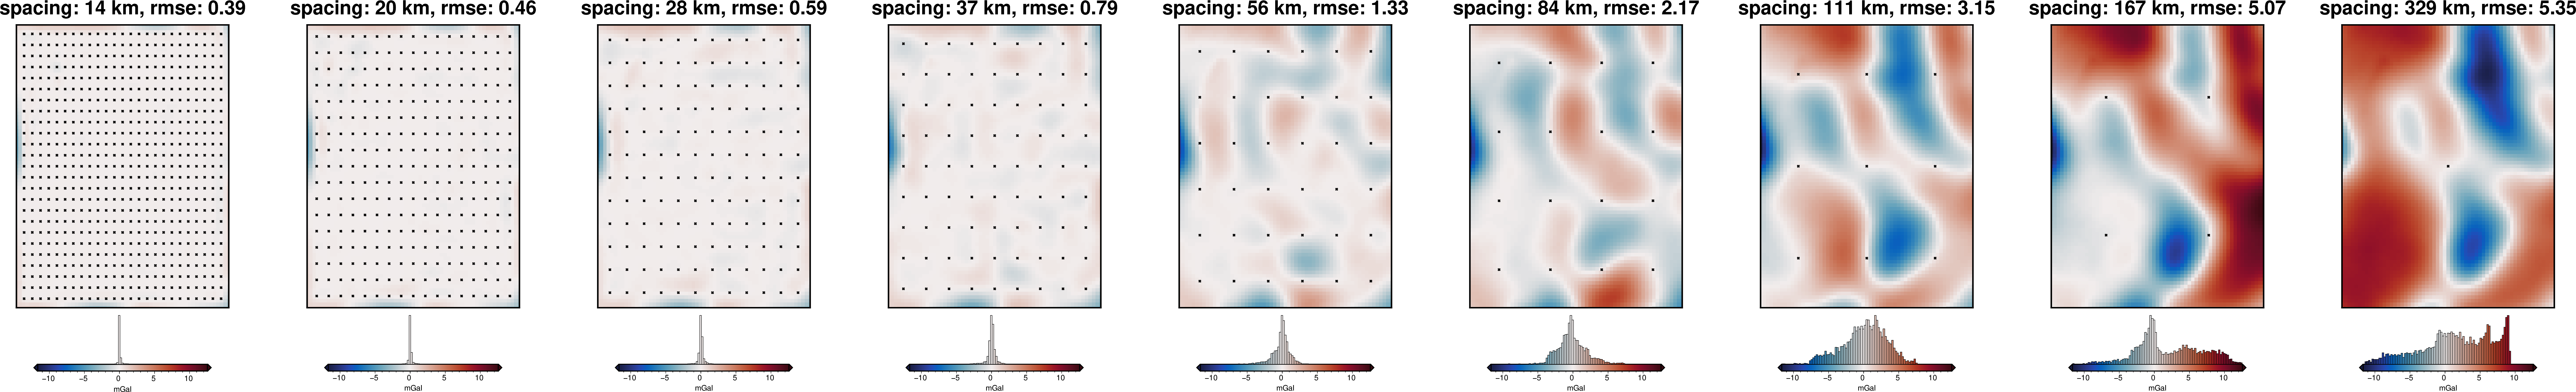

In [122]:
cpt_lims = polar_utils.get_combined_min_max([g.basement_grav - g.reg for g in grav_grids])

rmses = []
for i, g in enumerate(grav_grids):
    if i == 0:
        fig = None
        origin_shift="initialize"
    else:
        origin_shift="xshift"

    dif = (g.basement_grav - g.reg)
    fig = maps.plot_grd(
        dif,
        region=inversion_region,
        fig_height=10,
        fig=fig,
        origin_shift=origin_shift,
        xshift_amount=1.3,
        title=f"spacing: {round(constraints_spacings[i]/1e3)} km, rmse: {round(utils.rmse(dif),2)}",
        cmap="balance+h0",
        cpt_lims=cpt_lims,
        hist=True,
        cbar_label="mGal",
        # frame=["nSwE", "xaf10000", "yaf10000"],
        points=constraints_dfs[i],
        points_style="x.1c",
    )
    rmses.append(utils.rmse(dif))

fig.show()

<Axes: >

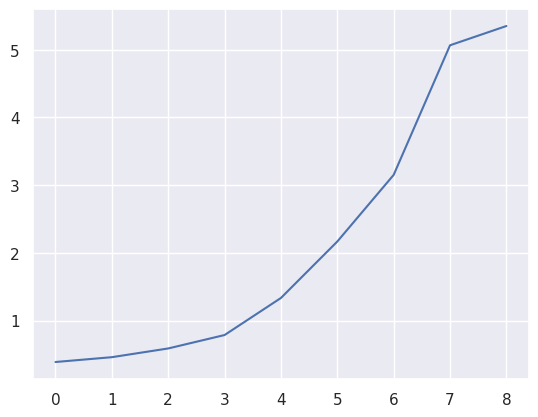

In [123]:
pd.Series(rmses).plot()

In [10]:
# set kwargs to pass to the inversion
kwargs = {
    # set stopping criteria
    "max_iterations": 200,
    "l2_norm_tolerance": .01**.5, # square root of the gravity noise
    "delta_l2_norm_tolerance": 1.008,
}


  0%|          | 0/9 [00:00<?, ?it/s]

INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_07_damping_cv_constraint_spacing_25'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.0121848087031416}
INFO:invert4geom:	scores: [0.035403306462249165]
INFO:invert4geom:results saved to ../../results/Ross_Sea_07_damping_cv_constraint_spacing_25_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_07_damping_cv_constraint_spacing_17'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.01218480870314159}
INFO:invert4geom:	scores: [0.03548780898244357]
INFO:invert4geom:results saved to ../../results/Ross_Sea_07_damping_cv_constraint_spacing_17_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_07_damping_cv_constraint_spacing_12'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 4
INFO:invert4geom:	parameter: {'damping': 0.024278603503688368}
INFO:invert4geom:	scores: [0.039236159010687145]
INFO:invert4geom:results saved to ../../results/Ross_Sea_07_damping_cv_constraint_spacing_12_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_07_damping_cv_constraint_spacing_9'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.012184809458564254}
INFO:invert4geom:	scores: [0.04568219064013197]
INFO:invert4geom:results saved to ../../results/Ross_Sea_07_damping_cv_constraint_spacing_9_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_07_damping_cv_constraint_spacing_6'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.03483775109571783}
INFO:invert4geom:	scores: [0.05374800335229061]
INFO:invert4geom:results saved to ../../results/Ross_Sea_07_damping_cv_constraint_spacing_6_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_07_damping_cv_constraint_spacing_4'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.01218480870314159}
INFO:invert4geom:	scores: [0.05639715621858108]
INFO:invert4geom:results saved to ../../results/Ross_Sea_07_damping_cv_constraint_spacing_4_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_07_damping_cv_constraint_spacing_3'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.0121848087031416}
INFO:invert4geom:	scores: [0.08932746458591977]
INFO:invert4geom:results saved to ../../results/Ross_Sea_07_damping_cv_constraint_spacing_3_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_07_damping_cv_constraint_spacing_2'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 2
INFO:invert4geom:	parameter: {'damping': 0.012184809458564264}
INFO:invert4geom:	scores: [0.1745548695106404]
INFO:invert4geom:results saved to ../../results/Ross_Sea_07_damping_cv_constraint_spacing_2_results.pickle.pickle
INFO:invert4geom:saving all results with root name '../../results/Ross_Sea_07_damping_cv_constraint_spacing_1'
INFO:invert4geom:running damping cross validation


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:invert4geom:Trial with best score: 
INFO:invert4geom:	trial number: 3
INFO:invert4geom:	parameter: {'damping': 0.03484768545236371}
INFO:invert4geom:	scores: [0.0751583905783583]
INFO:invert4geom:results saved to ../../results/Ross_Sea_07_damping_cv_constraint_spacing_1_results.pickle.pickle


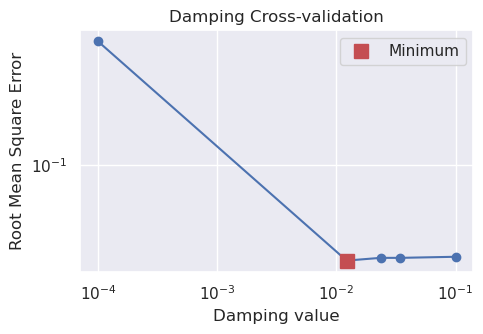

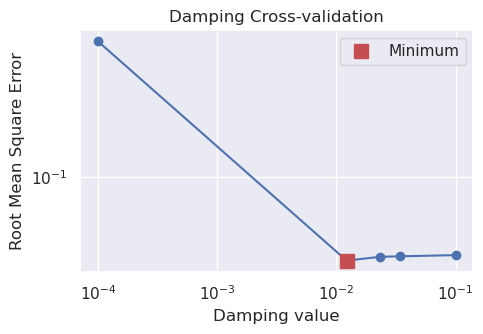

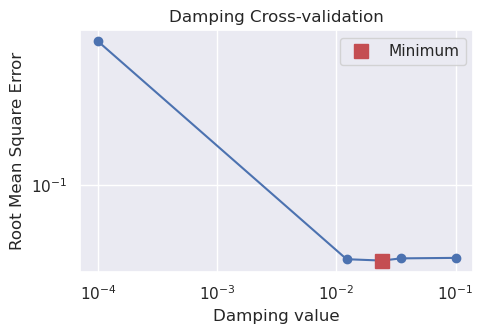

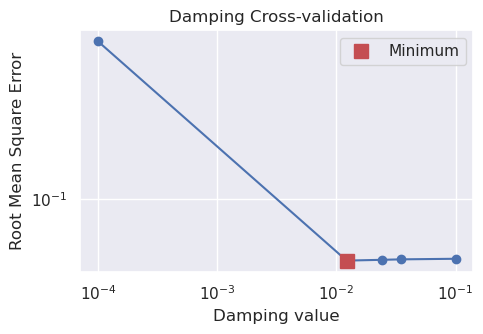

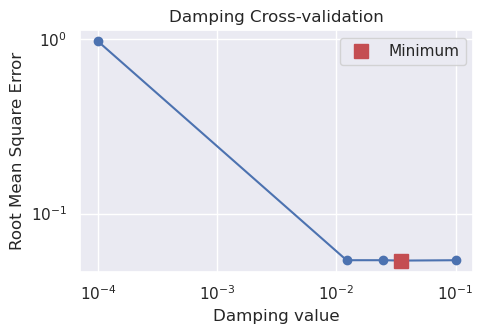

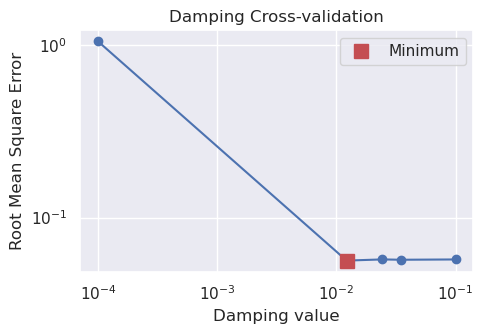

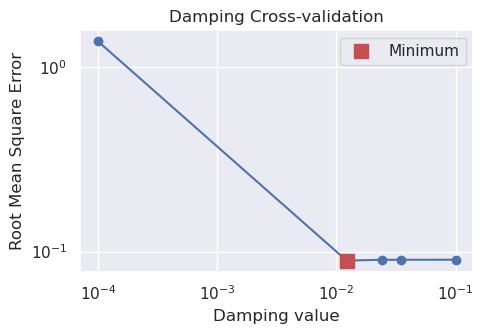

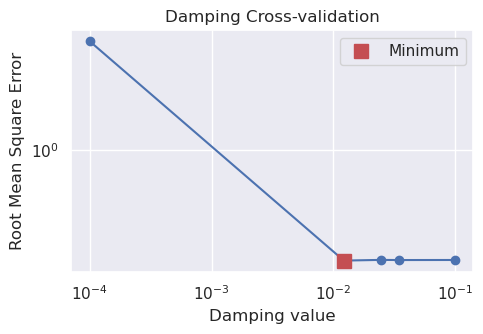

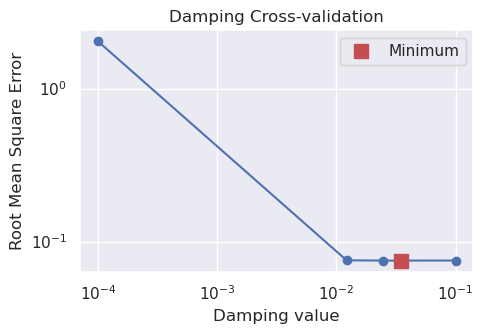

In [11]:
logging.getLogger().setLevel(logging.INFO)

for i, df in enumerate(tqdm(grav_dfs)):
    # run the inversion workflow, including a cross validation for the damping parameter
    inversion.run_inversion_workflow(
        grav_df=df,
        starting_prisms=starting_prism_layers[i],
        # for creating test/train splits
        grav_spacing=spacing,
        inversion_region=inversion_region,
        # solver_damping=0.01,
        run_damping_cv=True,
        damping_limits=(0.0001, 0.1),
        damping_cv_trials=5,
        plot_cv=True,
        fname=f"../../results/Ross_Sea_07_damping_cv_constraint_spacing_{constraint_numbers[i]}",
        **kwargs,
    )


In [12]:
scores = []
rmses = []
dampings = []
starting_rmses = []

for i, n in enumerate(constraint_numbers):
    fname=f"../../results/Ross_Sea_07_damping_cv_constraint_spacing_{n}"

    with pathlib.Path(f"{fname}_results.pickle").open("rb") as f:
        results = pickle.load(f)

    with pathlib.Path(f"{fname}_damping_cv_study.pickle").open("rb") as f:
        study = pickle.load(f)
    dampings.append(study.best_params["damping"])
    scores.append(study.best_value)

    starting_topo = results[0].set_index(["northing", "easting"]).to_xarray().starting_topo
    final_topo = results[0].set_index(["northing", "easting"]).to_xarray().topo

    inside_starting_topo = starting_topo.sel(
        northing=slice(inversion_region[2], inversion_region[3]),
        easting=slice(inversion_region[0], inversion_region[1]),
    )
    inside_final_topo = final_topo.sel(
        northing=slice(inversion_region[2], inversion_region[3]),
        easting=slice(inversion_region[0], inversion_region[1]),
    )
    inside_bathy = bathymetry.sel(
        northing=slice(inversion_region[2], inversion_region[3]),
        easting=slice(inversion_region[0], inversion_region[1]),
    )
    rmse = utils.rmse(inside_final_topo-inside_bathy)
    rmses.append(rmse)

    starting_rmse = utils.rmse(inside_starting_topo-inside_bathy)
    starting_rmses.append(starting_rmse)

ensemble_df = pd.DataFrame(
    {
        "constraint_numbers": constraint_numbers,
        "constraint_spacing_km": [c/1e3 for c in constraints_spacings],
        "score": scores,
        "rmse": rmses,
        "dampings": dampings,
        "starting_errors": starting_rmses,
    }
)
ensemble_df

,constraint_numbers,constraint_spacing_km,score,rmse,dampings,starting_errors
0,25,14.000000,0.035403,8.623034,0.012185,9.718879
1,17,20.588235,0.035488,9.797251,0.012185,15.273710
2,12,29.166667,0.039236,12.294201,0.024279,21.528398
3,9,38.888889,0.045682,16.239922,0.012185,33.832672
4,6,58.333333,0.053748,26.123114,0.034838,51.121787
5,4,87.500000,0.056397,39.537735,0.012185,78.972128
6,3,116.666667,0.089327,56.333219,0.012185,146.303443
7,2,175.000000,0.174555,99.684622,0.012185,272.331483
8,1,350.000000,0.075158,90.189221,0.034848,164.157748


In [13]:
# compare starting and actual bathymetry grids
grids = polar_utils.grd_compare(
    bathymetry,
    starting_bathymetry,
    region=inversion_region,
)
starting_rmse = utils.rmse(grids[0])

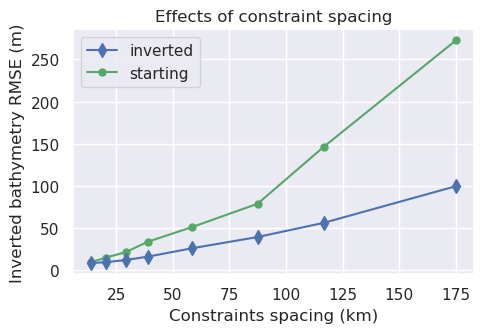

In [17]:
RIS_plotting.plot_1var_ensemble(
    df=ensemble_df[ensemble_df.constraint_spacing_km < 300],
    x="constraint_spacing_km",
    y="rmse",
    title="Effects of constraint spacing",
    xlabel="Constraints spacing (km)",
    ylabel="Inverted bathymetry RMSE (m)",
    # horizontal_line=starting_rmse,
    # horizontal_line_label="Starting RMSE",
    plot_starting_error=True,
    # logx=True,
)

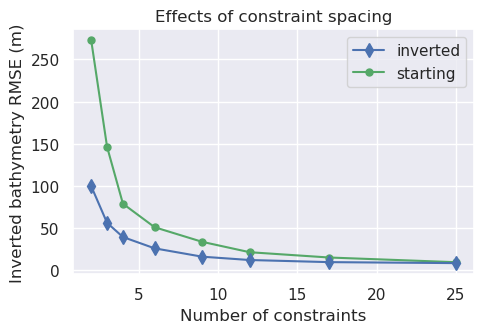

In [18]:
RIS_plotting.plot_1var_ensemble(
    df=ensemble_df[ensemble_df.constraint_spacing_km < 300],
    x="constraint_numbers",
    y="rmse",
    title="Effects of constraint spacing",
    xlabel="Number of constraints",
    ylabel="Inverted bathymetry RMSE (m)",
    # horizontal_line=starting_rmse,
    # horizontal_line_label="Starting RMSE",
    plot_starting_error=True,
    # logx=True,
)